# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Prediction of the response of a customer to an offer


In [437]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

In [438]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Clean and Analyze portfolio data

In [439]:
# show portfolio data
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [440]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [441]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [442]:
# Change name of feature id to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [443]:
portfolio.groupby(['offer_type'])['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

In [444]:
# Calculate unique values of feature offer_type
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [445]:
# show offer id's for each offer type
bogo_id = portfolio[portfolio['offer_type'] == 'bogo']['offer_id'].values.tolist()
bogo_id


['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'f19421c1d4aa40978ebb69ca19b0e20d']

In [446]:
discount_id = portfolio[portfolio['offer_type'] == 'discount']['offer_id'].values.tolist()
discount_id


['0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '2906b810c7d4411798c6938adc9daaa5']

In [447]:
inform_id = portfolio[portfolio['offer_type'] == 'informational']['offer_id'].values.tolist()
inform_id

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

In [448]:
# Convert time feature from days to hours
portfolio['duration'] = portfolio['duration']*24

# Make separate columns for values in feature channels list
portfolio['web'] = portfolio['channels'].apply(lambda x: int(1) if 'web' in x else int(0))
portfolio['email'] = portfolio['channels'].apply(lambda x: int(1) if 'email' in x else int(0))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: int(1) if 'mobile' in x else int(0))
portfolio['social'] = portfolio['channels'].apply(lambda x: int(1) if 'social' in x else int(0))

# Drop channels column
portfolio.drop(columns=['channels'],axis=1, inplace=True)

# OneHotEncoding fetaure offer_type
portfolio = pd.get_dummies(portfolio, columns=['offer_type'], prefix='', prefix_sep='')

# Re-order columns of portfolio dataframe
col_order = ['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount', 'informational', 'web', 'email',\
             'mobile', 'social']
portfolio = portfolio.reindex(col_order, axis=1)



## clean and Analyze profile data

In [449]:
# show  profile data 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [450]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [451]:
profile.shape

(17000, 5)

In [452]:
profile.isnull().sum(0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [453]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [454]:
# Change name of feature id to customer_id in profile dataframe
profile.rename(columns={'id': 'customer_id'}, inplace=True)


In [455]:
profile['became_member_on'].max()

20180726

In [456]:
# Calculate count of unique gender
profile['gender'].value_counts().sort_values(ascending=False)

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [457]:
# Analyse maximum age of 118
profile_age_118 = profile[profile['age'] == 118]
profile_age_118.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Text(0.5,0,'Age')

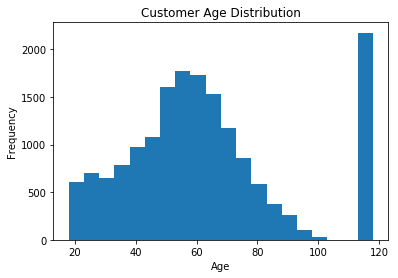

In [458]:
customer_age = profile['age'].plot(kind='hist', bins=20, title='Customer Age Distribution')
customer_age.set_xlabel("Age")

In [459]:
# Number of observations with age 118
profile_age_118.shape[0]

2175

In [460]:
# Calculate unique customer_id's with age 118
len(profile[profile['age'] == 118]['customer_id'].unique())

2175

In [461]:
#drop age 118 as gender and income data are not available for this age
#convert age 118 to "not a number"

profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
profile.dropna(inplace=True)


Text(0.5,0,'Age')

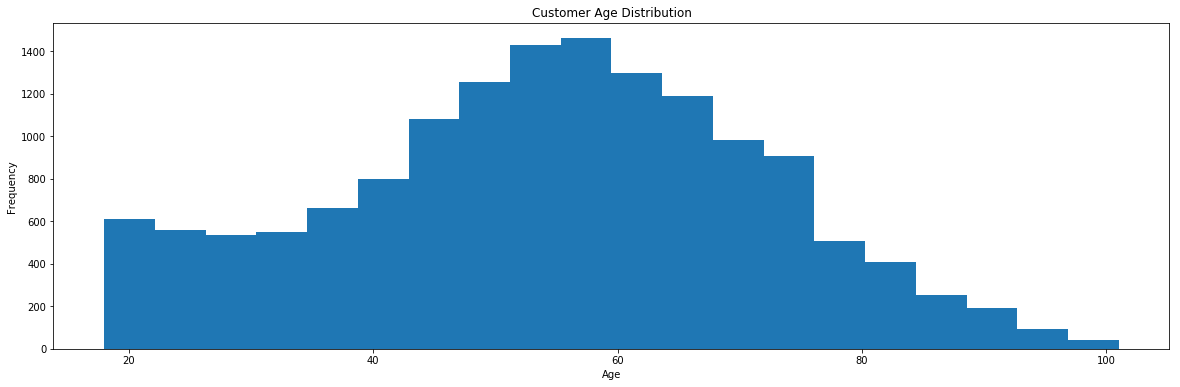

In [462]:
customer_age = profile['age'].plot(kind='hist', bins=20,figsize=(20,6), title='Customer Age Distribution')
customer_age.set_xlabel("Age")

In [463]:
# Print profile dataframe info after removing customers with age 118
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null float64
became_member_on    14825 non-null int64
gender              14825 non-null object
customer_id         14825 non-null object
income              14825 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 694.9+ KB


#### Analyze feature 'age'

In [464]:
# Convert fetaure 'age' into 'age_bins' & 'age_by_decade' which would be helpful in determining
# if a particular age is influenced more by an offer
profile['age_bins'] = pd.cut(profile['age'], bins=range(10,120,10), right=False)
profile['age_by_decade'] = pd.cut(profile['age'], bins=range(10,120,10),\
                                  right=False, labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s', '100s'])

In [465]:
profile.head()

,age,became_member_on,gender,customer_id,income,age_bins,age_by_decade
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,"[50, 60)",50s
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,"[70, 80)",70s
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,"[60, 70)",60s
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,"[60, 70)",60s
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,"[50, 60)",50s


In [466]:
# Print unique 'age_bins'
profile['age_bins'].unique()

[[50, 60), [70, 80), [60, 70), [20, 30), [40, 50), [30, 40), [90, 100), [80, 90), [10, 20), [100, 110)]
Categories (10, interval[int64]): [[10, 20) < [20, 30) < [30, 40) < [40, 50) ... [70, 80) < [80, 90) < [90, 100) < [100, 110)]

In [467]:
# Print value count of each unique 'age_bins'
profile['age_bins'].value_counts().sort_index()

[10, 20)       205
[20, 30)      1369
[30, 40)      1526
[40, 50)      2309
[50, 60)      3541
[60, 70)      2991
[70, 80)      1782
[80, 90)       831
[90, 100)      254
[100, 110)      17
Name: age_bins, dtype: int64

In [468]:
# Print unique 'age_by_decade'
profile['age_by_decade'].unique()

[50s, 70s, 60s, 20s, 40s, 30s, 90s, 80s, 10s, 100s]
Categories (10, object): [10s < 20s < 30s < 40s ... 70s < 80s < 90s < 100s]

In [469]:
# Print value count of each unique 'age_by_decade'
profile['age_by_decade'].value_counts().sort_index()

10s      205
20s     1369
30s     1526
40s     2309
50s     3541
60s     2991
70s     1782
80s      831
90s      254
100s      17
Name: age_by_decade, dtype: int64

In [470]:
# Drop feature 'age' & age_bins'
profile.drop(columns=['age', 'age_bins'], inplace=True)
profile.head()

,became_member_on,gender,customer_id,income,age_by_decade
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50s
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70s
5,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,60s
8,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,60s
12,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,50s


In [471]:
# OneHotEncoding feature 'age_by_decade'
profile = pd.get_dummies(profile, columns=['age_by_decade'], prefix='age', prefix_sep='_')
profile.head()

,became_member_on,gender,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,0,0
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,0,0
5,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,0,0
8,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,0,0
12,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,0,0


#### Analyze feature 'became_member_on'

In [472]:
# Print type of feature 'became_member_on'
type(profile['became_member_on'])

pandas.core.series.Series

In [473]:
# Convert type of feature 'became_member_on' to type Datetime
type(pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt)

pandas.core.indexes.accessors.DatetimeProperties

In [474]:
# Calculate year in which the customer became member
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year.value_counts().sort_index(ascending=True)

2013     274
2014     662
2015    1597
2016    3024
2017    5599
2018    3669
Name: became_member_on, dtype: int64

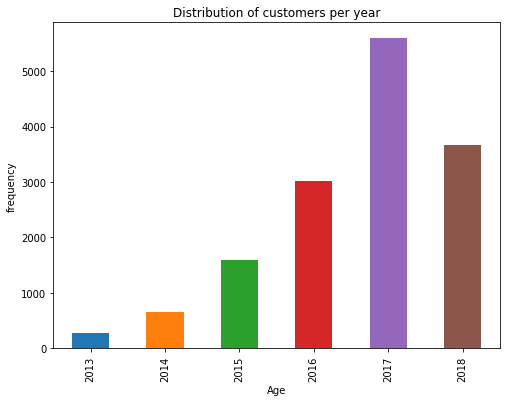

In [475]:
# Plot distribution of customer count per year in which the customer became member 
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year.value_counts().sort_index(ascending=True).plot.bar(figsize=(8,6));
plt.xlabel('Age')
plt.ylabel('frequency')
plt.title('Distribution of customers per year')
plt.show()

### From plot above , we can observe that the number of customers which became member increased every year except 2018. The last recorded data for 2018 was on 26.07.2018. 

### Assuming a linear increase based on history, the total number of cutsomers at the end of 2018 will likely almost double.

### Therefore, we can conculde that the customer membership increased every year.**

In [476]:
# Calculate month in which the customer became member
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.month.value_counts().sort_values(ascending=False)

8     1395
10    1386
12    1372
1     1327
9     1299
11    1268
7     1189
5     1152
3     1145
4     1145
6     1105
2     1042
Name: became_member_on, dtype: int64

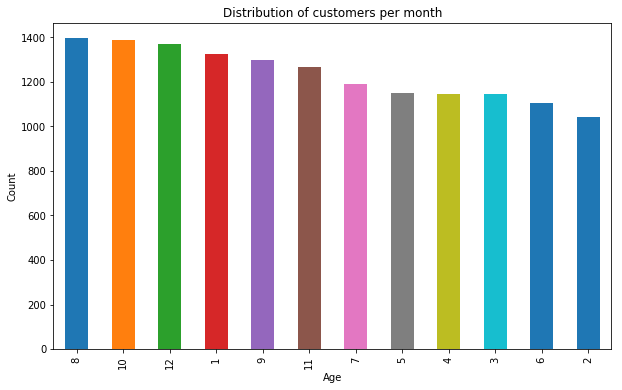

In [477]:
# Plot distribution of customer count per month in which the customer became member 
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.month.value_counts().plot.bar(figsize=(10,6));
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of customers per month')
plt.show()

**The distributions shows the highest number of customers in Augusgt, October and december and the lowest  the months od March, July and February.**

In [478]:
# Create feature 'membership_tenure' of customers from feature 'became_member_on'
profile['membership_tenure'] = (datetime.today().date() - pd.to_datetime(profile['became_member_on'],\
                                                                     format='%Y%m%d').dt.date).dt.days

# Create feature 'membership_year' in which customer became member from feature 'became_member_on'
profile['membership_year'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year

# Create feature 'membership_month' in which customer became member from feature 'became_member_on'
profile['membership_month'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.month

# Drop feature 'became_member_on'
profile.drop(columns=['became_member_on'], axis=1, inplace=True)
profile.head()

,gender,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,membership_tenure,membership_year,membership_month
1,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,0,0,1038,2017,7
3,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,0,0,1105,2017,5
5,M,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,0,0,753,2018,4
8,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,0,0,829,2018,2
12,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,0,0,919,2017,11


#### Analyze feature 'gender'

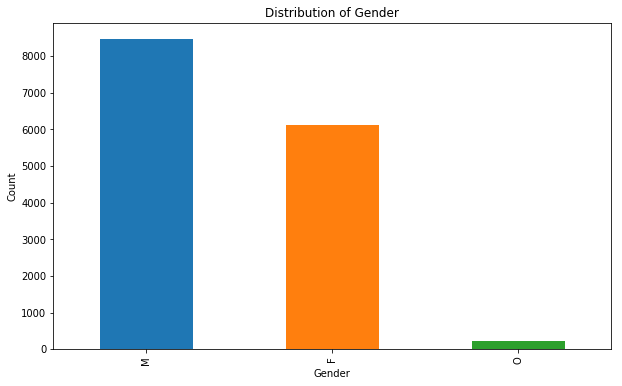

In [479]:
# Plot distribution of gender in profile dataframe
profile['gender'].value_counts().plot.bar(figsize=(10,6));
plt.xlabel('Gender')
plt.ylabel('Count')
#plt.xticks(rotation='horizontal')
plt.title('Distribution of Gender')
plt.show()

In [480]:
profile['gender'].value_counts(normalize = True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

**There are more males members than female members i.e 57% male and 41% female**.

#### Analyze feature 'income'

Text(0.5,0,'income')

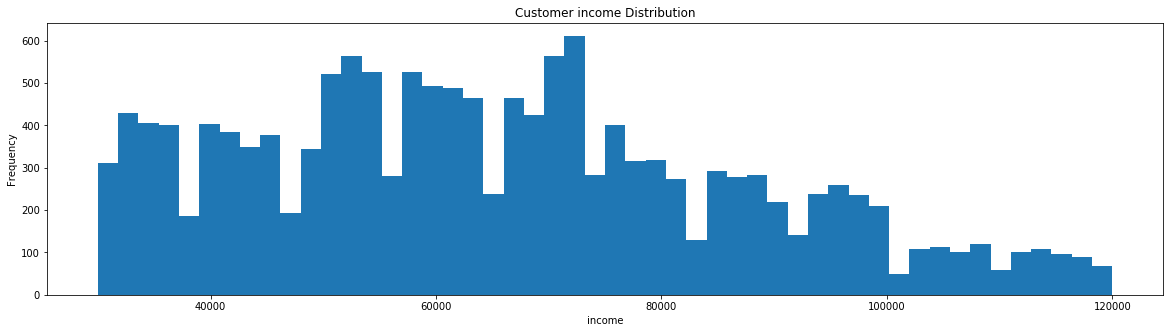

In [481]:
customer_income = profile['income'].plot(kind='hist', bins=50, figsize=(20,5),title='Customer income Distribution')
customer_income.set_xlabel("income")

**From above plot, we can observe that income appears to be non-uniformaly distributed across income range and have low distribution with high income which seems reasonable**.

Text(0.5,0,'Male income')

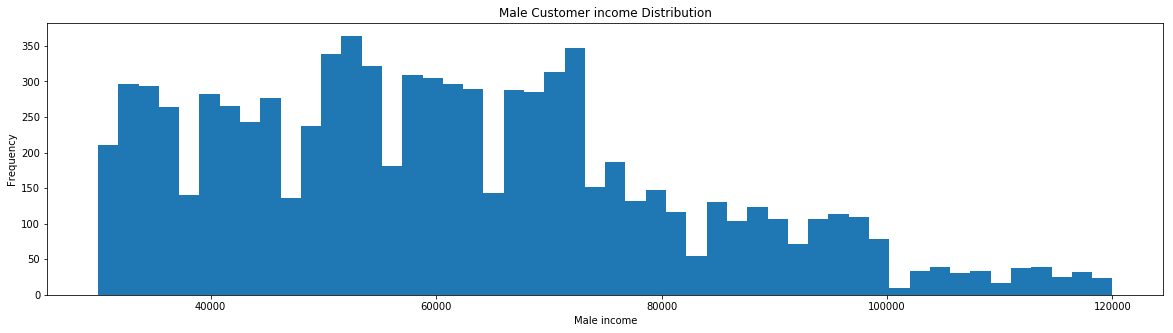

In [482]:

customer_income_M = profile.loc[profile['gender'] == 'M', 'income'].plot(kind='hist', bins=50, figsize=(20,5),title='Male Customer income Distribution')
customer_income_M.set_xlabel("Male income")



Text(0.5,0,'Female income')

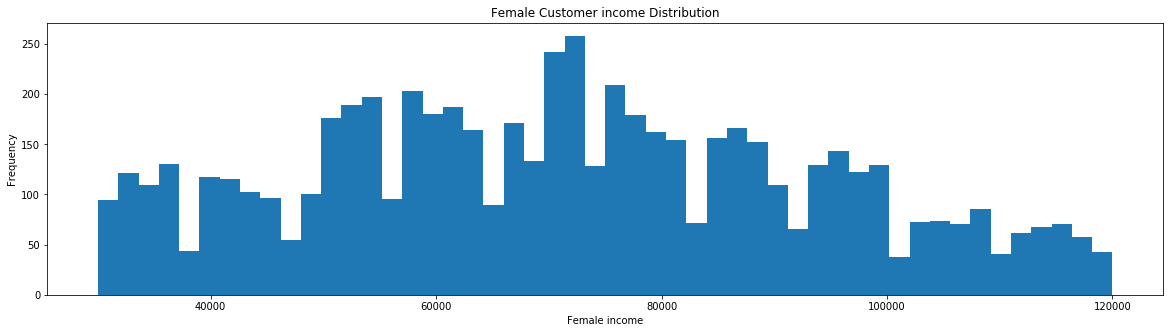

In [483]:

customer_income_F = profile.loc[profile['gender'] == 'F', 'income'].plot(kind='hist', bins=50, figsize=(20,5),title='Female Customer income Distribution')
customer_income_F.set_xlabel("Female income")



Text(0.5,0,'Other income')

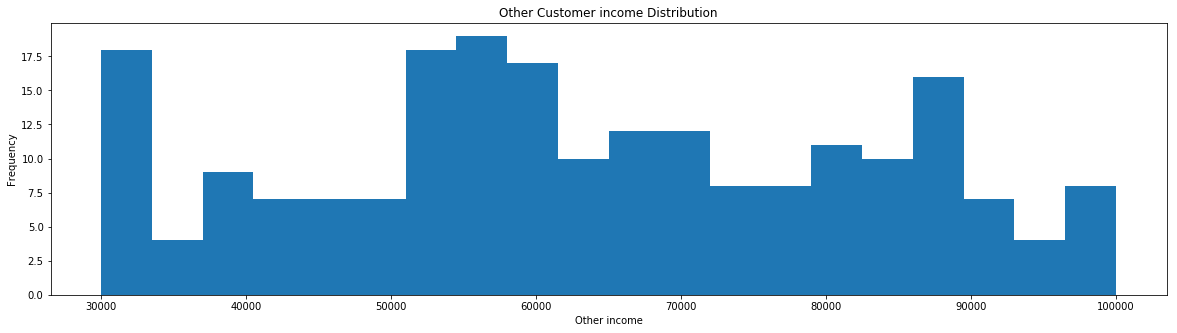

In [484]:

customer_income_O = profile.loc[profile['gender'] == 'O', 'income'].plot(kind='hist', bins=20, figsize=(20,5),title='Other Customer income Distribution')
customer_income_O.set_xlabel("Other income")



In [485]:
# OneHotEncoding feature 'membership_year'
profile = pd.get_dummies(profile, columns=['membership_year'], prefix='', prefix_sep='')

# OneHotEncoding feature 'membership_month'
profile = pd.get_dummies(profile, columns=['membership_month'], prefix='month', prefix_sep='_')

# OneHotEncoding feature 'gender'
profile = pd.get_dummies(profile, columns=['gender'], prefix='', prefix_sep='')

profile.head()

,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,F,M,O
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [486]:
# Create bins of feature 'income'
pd.cut(profile['income'], bins=range(30000,140000,10000), right=False).values

[[110000, 120000), [100000, 110000), [70000, 80000), [50000, 60000), [50000, 60000), ..., [50000, 60000), [70000, 80000), [70000, 80000), [50000, 60000), [80000, 90000)]
Length: 14825
Categories (10, interval[int64]): [[30000, 40000) < [40000, 50000) < [50000, 60000) < [60000, 70000) ... [90000, 100000) < [100000, 110000) < [110000, 120000) < [120000, 130000)]

In [487]:
# Convert feature 'income' into 'income_by_range' which would be helpful in determining
# if a particular income range is influenced more by an offer
profile['income_by_range'] = pd.cut(profile['income'], bins=range(30000,140000,10000), right=False,\
                                    labels=['30ths','40ths', '50ths', '60ths', '70ths','80ths', '90ths',\
                                            '100ths', '110ths', '120ths'])
profile.head()

,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,...,month_7,month_8,month_9,month_10,month_11,month_12,F,M,O,income_by_range
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,110ths
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,100ths
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,70ths
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,50ths
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,50ths


In [489]:
# Drop feature 'income'
profile.drop(columns=['income'], inplace=True)

In [490]:
# OneHotEncoding feature 'income_by_range'
profile = pd.get_dummies(profile, columns=['income_by_range'], prefix='income', prefix_sep='_')
profile.head()

,customer_id,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [491]:
# Print column names of profile dataframe
profile.columns

Index(['customer_id', 'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s',
       'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s',
       'membership_tenure', '2013', '2014', '2015', '2016', '2017', '2018',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'F', 'M', 'O', 'income_30ths', 'income_40ths', 'income_50ths',
       'income_60ths', 'income_70ths', 'income_80ths', 'income_90ths',
       'income_100ths', 'income_110ths', 'income_120ths'],
      dtype='object')

In [492]:
# Print number of columns
len(profile.columns)

43

In [493]:
# Re-order columns of profile dataframe
profile_col_order = ['customer_id', 'membership_tenure', 'F', 'M', 'O',\
                     'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s',\
                     'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s',\
                     '2013', '2014', '2015', '2016', '2017', '2018',\
                     'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',\
                     'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',\
                     'income_30ths', 'income_40ths', 'income_50ths','income_60ths', 'income_70ths',\
                     'income_80ths', 'income_90ths','income_100ths', 'income_110ths', 'income_120ths']

profile = profile.reindex(profile_col_order, axis=1)
profile.head()

,customer_id,membership_tenure,F,M,O,age_10s,age_20s,age_30s,age_40s,age_50s,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,0610b486422d4921ae7d2bf64640c50b,1038,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1105,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,753,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,829,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,919,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [494]:
# Print shape of profile dataframe
profile.shape

(14825, 43)

## Clean and  Analyze transcript data

In [495]:
# Load transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [496]:
# Print transcript dataframe info
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [497]:
# Print shape of transcript dataframe
transcript.shape

(306534, 4)

In [498]:
# Calculate null values in transcript dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [499]:
# # Change name of feature person to customer_id in transcript dataframe
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [500]:
# Compute number of observations in transcript dataframe with customers having age 118
id_age_118 = profile_age_118['customer_id'].unique().tolist()
print(transcript['customer_id'].isin(id_age_118).value_counts())

False    272762
True      33772
Name: customer_id, dtype: int64


In [501]:
# Percentage of observations in transcript dataframe with customers having age 118
round((transcript['customer_id'].isin(id_age_118).sum()/transcript.shape[0])*100,2)

11.02

In [502]:
# Remove observations having customers with age 118 from transcript dataframe
transcript = transcript[~transcript['customer_id'].isin(id_age_118)]
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [503]:
# Shape of trancript dataframe after removing observations of customers with age 118
transcript.shape

(272762, 4)

In [504]:
# Check if customers with age 118 has been removed from transcript dataframe
transcript['customer_id'].isin(id_age_118).sum()

0

In [235]:
# Calculate unique values in event feature
transcript['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [505]:
# Calculate percentage of transaction and offer events
event_transaction = transcript['event'].value_counts()[0]
event_offers = transcript['event'].value_counts()[1:].sum()
event_total = transcript['event'].shape[0]

print('Percentage of transaction events are: {}%'.format(round((event_transaction/event_total)*100,2)))
print('Percentage of offers events are: {}%'.format(round((event_offers/event_total)*100,2)))

Percentage of transaction events are: 45.45%
Percentage of offers events are: 54.55%


In [506]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [507]:
# Print features of transcript dataframe
transcript.columns

Index(['event', 'customer_id', 'time', 'value'], dtype='object')

## Create Offers and transaction dataframe

In [508]:
# Create dataframe offers_df containing only offers events and transaction_df containing only transaction event
# Create a list of offer event types
offer_event_list = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = transcript[transcript['event'].isin(offer_event_list)].index

# Find index where feature event is 'transaction'
transaction_index = transcript[~transcript['event'].isin(offer_event_list)].index

# Create offers_df
offers_df = transcript.loc[offer_index,:]

# Create transaction_df
transaction_df = transcript.loc[transaction_index,:]

In [509]:
# Print unique values in feature event in offers_df
offers_df['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [510]:
# Print unique values in feature event in transaction_df
transaction_df['event'].unique()

array(['transaction'], dtype=object)

**From above, we can observe that dataframe offers_df contains only events 'offer received', 'offer viewed' and 'offer completed' and dataframe transaction_df contains only event 'transaction'**.

In [511]:
# Print value counts in feature offers_df
offers_df['event'].value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

In [512]:
# Print value counts in feature transaction_df
transaction_df['event'].value_counts()

transaction    123957
Name: event, dtype: int64

In [513]:
# Print total number of observations in offers_df and transction_df
offers_df.shape[0] + transaction_df.shape[0]

272762

In [514]:
# Create function to retrieve offer_id from feature value
def func_value_offer_id(x):
    for k,v in x.items():
        if k in ['offer id','offer_id']:
            return str(v)
        elif k not in ['offer id','offer_id', 'reward']:
            print('key {} not in dict'.format(k))

In [515]:
# Create column 'offer_id' and filling in the values using function func_value_offer_id
offers_df.loc[:,'offer_id'] = offers_df['value'].apply(func_value_offer_id)

In [516]:
offers_df.head()

,event,customer_id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [517]:
# Print unique offer_id in offers_df
offers_df['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '2906b810c7d4411798c6938adc9daaa5',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '3f207df678b143eea3cee63160fa8bed',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [518]:
# Create another column 'offer_type' with respect to feature 'offer_id'
offers_df['offer_type'] = offers_df['offer_id'].copy()



offers_df['offer_type'].replace(['ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',\
                                 '9b98b8c7a33c4b65b9aebfe6a799e6d9','f19421c1d4aa40978ebb69ca19b0e20d'],\
                                 'bogo', inplace=True)

offers_df['offer_type'].replace(['0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',\
                                 'fafdcd668e3743c1bb461111dcafc2a4','2906b810c7d4411798c6938adc9daaa5'],\
                                 'discount', inplace=True)

offers_df['offer_type'].replace(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'],\
                                 'informational', inplace=True)

offers_df.head()

,event,customer_id,time,value,offer_id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,discount
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,bogo
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,informational
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,discount


In [519]:
# Calculate the count of customers by grouping offer type and event
offers_df.groupby(['offer_type', 'event'])['customer_id'].count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64

In [520]:
# Transform offers_df
# Drop feature value as it is not required now and drop feature offer_type as that information is also in portfolio dataframe
# as well
offers_df.drop(columns=['value', 'offer_type'], inplace=True)

# OneHotEncoding feature 'income_by_range'
offers_df = pd.get_dummies(offers_df, columns=['event'], prefix='', prefix_sep='')

# Change column names
offers_df.rename(columns = {'offer received': 'offer_recd',
                            'offer viewed': 'offer_view',
                            'offer completed': 'offer_comp'}, inplace=True)

# Re-order columns of offers_df dataframe
offers_df_col_order = ['customer_id', 'offer_id', 'time', 'offer_recd', 'offer_view', 'offer_comp']

offers_df = offers_df.reindex(offers_df_col_order, axis=1)
offers_df.head()

,customer_id,offer_id,time,offer_recd,offer_view,offer_comp
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [521]:
# Transform transaction_df
# Create column 'amount'
transaction_df.loc[:,'amount'] = transaction_df['value'].apply(lambda x: x['amount'])

# Drop feature 'event' & 'value'
transaction_df.drop(columns=['event', 'value'], inplace=True)
transaction_df.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


## Combine transaction, demographic and offer data

In [522]:
# Install progressbar in the current Jupyter kernel with pip install
import sys
!{sys.executable} -m pip install progressbar
from progressbar import ProgressBar, Percentage, Bar, RotatingMarker, ETA, FileTransferSpeed

In [523]:
# Create function to combine transaction, demographic and offer data
def create_combined_data(portfolio, profile, offers_df, transaction_df, combined_data_path='./data/combined_data.csv'):
    '''Create a combined dataframe from the transaction, demographic and offer data:
    INPUT:
        portfolio - (dataframe),offer metadata
        profile - (dataframe),customer demographic data
        offers_df - (dataframe), offers data for customers
        transaction_df - (dataframe), transaction data for customers
        combined_data_path - (filepath), path of a .csv file
    OUTPUT:
        combined_data_df - (dataframe),combined data from transaction, demographic and offer data
    '''
    if os.path.exists(combined_data_path):
        print('Reading combined data .csv file')
        combined_data_df = pd.read_csv(combined_data_path)
        return combined_data_df
    else:
        combined_data = [] # Initialize empty list for combined data
        customer_id_list = offers_df['customer_id'].unique().tolist() # List of unique customers in offers_df
        
        # Create widget for progress bar
        widgets = [Percentage(), ' ', Bar(marker=RotatingMarker()), ' ', ETA(), ' ', FileTransferSpeed()]
        # Create and start progressbar
        pbar = ProgressBar(widgets=widgets, maxval=len(customer_id_list)).start()

        # Iterate over each customer
        for idx,cust_id in enumerate(customer_id_list):
            # Select a specific customer profile
            cust_profile = profile[profile['customer_id'] == cust_id] 
            # Select offers for a specific customer
            cust_offers_df = offers_df[offers_df['customer_id'] == cust_id]
            # Select transactions for a specific customer
            cust_transaction_df = transaction_df[transaction_df['customer_id'] == cust_id]
            # Select offers received by a specific customer
            cust_offers_recd_df = cust_offers_df[cust_offers_df['offer_recd'] == 1]
            # Select offers viewed by a specific customer
            cust_offers_view_df = cust_offers_df[cust_offers_df['offer_view'] == 1]
            # Select offers completed by a specific customer
            cust_offers_comp_df = cust_offers_df[cust_offers_df['offer_comp'] == 1]
            
            # Iterate over each offer received by a customer
            cust_offers_response = [] # Initialize empty list for a customer records
            
            for off_id in cust_offers_recd_df['offer_id'].values.tolist():
                # Look-up duration of a particular offer_id
                duration = portfolio.loc[portfolio['offer_id'] == off_id, 'duration'].values[0]
                # Look-up the time when offer was received
                off_recd_time = cust_offers_recd_df.loc[cust_offers_recd_df['offer_id'] == off_id, 'time'].values[0]
                # Calculate the time when the offer end
                off_end_time = off_recd_time + duration
                #Initialize a boolean array that determines if the customer viewed an offer between offer period
                offers_viewed = np.logical_and(cust_offers_view_df['time'] >= off_recd_time,\
                                               cust_offers_view_df['time'] <= off_end_time)
                
                # Check if the offer type is 'bogo' or 'discount'
                if (portfolio[portfolio['offer_id'] == off_id]['bogo'].values[0] == 1 or\
                    portfolio[portfolio['offer_id'] == off_id]['discount'].values[0] == 1):
                    #Initialize a boolean array that determines if the customer completed an offer between offer period
                    offers_comp = np.logical_and(cust_offers_comp_df['time'] >= off_recd_time,\
                                                 cust_offers_comp_df['time'] <= off_end_time)
                    
                    #Initialize a boolean array that selects customer transctions between offer period
                    cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                    
                    # Determine if the customer responded to an offer(bogo or discount) or not
                    cust_response = np.logical_and(offers_viewed.sum() > 0, offers_comp.sum() > 0) and\
                                                    (cust_tran_within_period['amount'].sum() >=\
                                                     portfolio[portfolio['offer_id'] == off_id]['difficulty'].values[0])
                
                # Check if the offer type is 'informational'
                elif portfolio[portfolio['offer_id'] == off_id]['informational'].values[0] == 1:
                    #Initialize a boolean array that determines if the customer made any transctions between offer period
                    cust_info_tran = np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                    cust_transaction_df['time'] <= off_end_time)                   
                    
                    # Determine if the customer responded to an offer(informational) or not
                    cust_response = offers_viewed.sum() > 0 and cust_info_tran.sum() > 0                  
                
                    #Initialize a boolean array that selects customer transctions between offer period
                    cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                
                # Initialize a dictionary for a customer with required information for a particular offer
                cust_rec = {'cust_response': int(cust_response),
                            'time': off_recd_time,
                            'total_amount': cust_tran_within_period['amount'].sum()}
                cust_rec.update(profile[profile['customer_id'] == cust_id].squeeze().to_dict())
                cust_rec.update(portfolio[portfolio['offer_id'] == off_id].squeeze().to_dict())
                
                # Add the dictionary to list for combined_data
                cust_offers_response.append(cust_rec)
            
            # Add the dictionaries from cust_offers_response list to combined_data list
            combined_data.extend(cust_offers_response)
            
            # Update progressbar
            pbar.update(idx+1)
        
        # Convert combined_data list to dataframe
        combined_data_df = pd.DataFrame(combined_data)
        
        # Re-order columns of combined_data_df
        combined_data_df_col_order = ['customer_id', 'offer_id', 'time']
#        combined_data_df_col_order = ['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward', 'bogo',\
#                                      'discount', 'informational', 'web', 'email', 'mobile', 'social', 'membership_tenure',\
#                                      'F', 'M', 'O', 'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s',\
#                                      'age_70s', 'age_80s', 'age_90s', 'age_100s', '2013', '2014', '2015', '2016', '2017',\
#                                      '2018', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',\
#                                      'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'income_30ths',\
#                                      'income_40ths', 'income_50ths', 'income_60ths', 'income_70ths', 'income_80ths',\
#                                      'income_90ths', 'income_100ths', 'income_110ths', 'income_120ths',\
#                                      'total_amount', 'cust_response']
        port_ls = portfolio.columns.tolist()
        port_ls.remove('offer_id')
        pro_ls = profile.columns.tolist()
        pro_ls.remove('customer_id')
        combined_data_df_col_order.extend(port_ls)
        combined_data_df_col_order.extend(pro_ls)
        combined_data_df_col_order.extend(['total_amount', 'cust_response'])
        
        combined_data_df = combined_data_df.reindex(combined_data_df_col_order, axis=1)
        
        # Finish progressbar
        pbar.finish()
        
        # Write combined_data_df to .csv file
        print('Saving combined_data_df to .csv file')
        combined_data_df.to_csv(combined_data_path, index=False)
        
        return combined_data_df

In [524]:
# Prepare Combined data from transaction, demographic and offer data
combined_data_df = create_combined_data(portfolio, profile, offers_df, transaction_df,\
                                        combined_data_path='./data/combined_data.csv')

Reading combined data .csv file


In [525]:
type(combined_data_df)

pandas.core.frame.DataFrame

In [526]:
combined_data_df.head()

,customer_id,offer_id,time,difficulty,duration,reward,bogo,discount,informational,web,...,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount,cust_response
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,168,5,1,0,0,1,...,0,0,0,0,0,1,0,0,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,0,72,0,0,0,1,0,...,0,0,0,0,0,1,0,0,49.39,1
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,10,168,10,1,0,0,0,...,0,0,0,0,0,1,0,0,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,120,5,1,0,0,1,...,0,0,0,0,0,1,0,0,48.28,1
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,10,168,2,0,1,0,1,...,0,0,1,0,0,0,0,0,0.00,0


In [527]:
# Print features of combined_data_df dataframe
combined_data_df.columns

Index(['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'bogo', 'discount', 'informational', 'web', 'email', 'mobile', 'social',
       'membership_tenure', 'F', 'M', 'O', 'age_10s', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s',
       'age_100s', '2013', '2014', '2015', '2016', '2017', '2018', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'income_30ths', 'income_40ths', 'income_50ths', 'income_60ths',
       'income_70ths', 'income_80ths', 'income_90ths', 'income_100ths',
       'income_110ths', 'income_120ths', 'total_amount', 'cust_response'],
      dtype='object')

### Analyze Offer Response Rate

In [528]:
# Create dataframe offer_response for distribution of offer_id, response_rate and offer_type
offer_response = combined_data_df.groupby(['offer_id'])['cust_response'].count().reset_index()
offer_response.rename(columns={'cust_response': 'count'}, inplace=True)
response_rate = combined_data_df.groupby(['offer_id'])['cust_response'].sum()/\
                combined_data_df.groupby(['offer_id'])['cust_response'].count()
np.round(response_rate.values*100,2)
offer_response['response_rate'] = np.round(response_rate.values*100,2)                                  
offer_response['offer_type'] = offer_response['offer_id'].map({'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',\
                                                               '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo',\
                                                               '3f207df678b143eea3cee63160fa8bed': 'informational',\
                                                               '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo',\
                                                               '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',\
                                                               '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount',\
                                                               'fafdcd668e3743c1bb461111dcafc2a4': 'discount',\
                                                               '5a8bc65990b245e5a138643cd4eb9837': 'informational',\
                                                               'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo',\
                                                               '2906b810c7d4411798c6938adc9daaa5': 'discount'})

offer_response.sort_values(by=['response_rate'], ascending=False)

,offer_id,count,response_rate,offer_type
9,fafdcd668e3743c1bb461111dcafc2a4,6652,75.20,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.28,discount
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,60.74,bogo
5,5a8bc65990b245e5a138643cd4eb9837,6643,54.72,informational
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,53.25,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,49.98,bogo
2,2906b810c7d4411798c6938adc9daaa5,6631,47.29,discount
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,47.28,bogo
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,41.85,discount
3,3f207df678b143eea3cee63160fa8bed,6657,36.76,informational


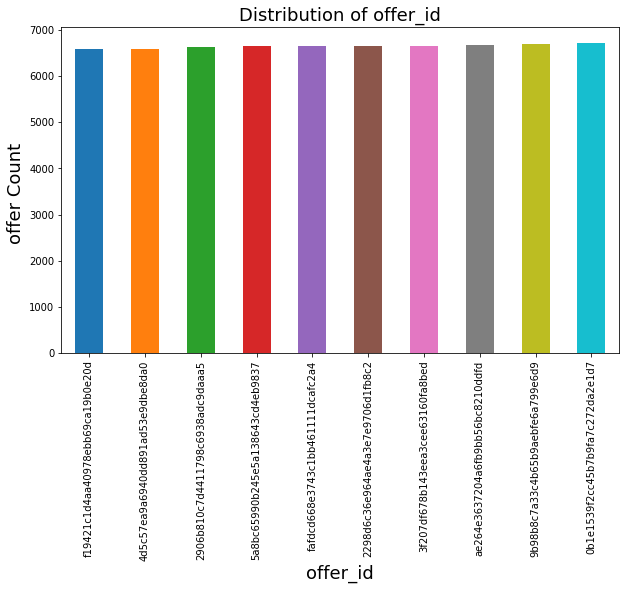

In [529]:
# Plot distribution of offer_id 
combined_data_df.groupby(['offer_id'])['cust_response'].count().sort_values(ascending=True).plot.bar(figsize=(10,6));
plt.xlabel('offer_id', fontsize=18)
plt.ylabel('offer Count ', fontsize=18)
plt.title('Distribution of offer_id', fontsize=18)
plt.show()

**From above, we can observe that the distribution of offers sent to customers are nearly and distribution is uniform**.

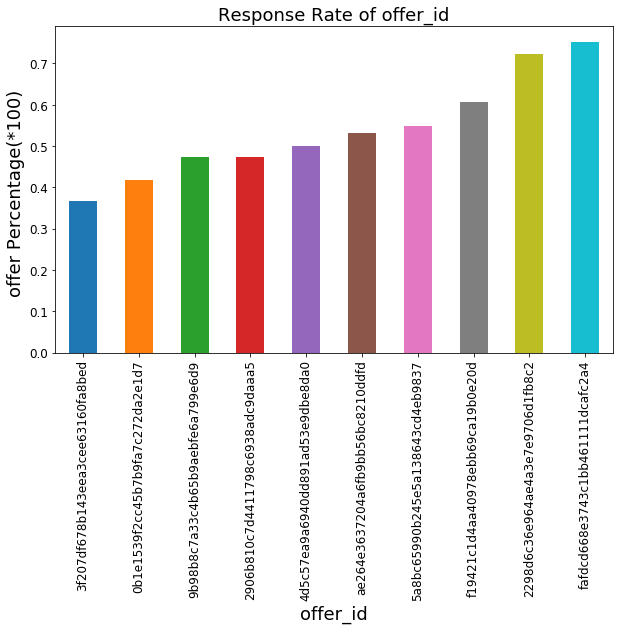

In [530]:
# Plot distribution of response_rate
response_rate.sort_values(ascending=True).plot.bar(figsize=(10,6), fontsize=12);
plt.xlabel('offer_id', fontsize=18)
plt.ylabel('offer Percentage(*100) ', fontsize=18)
plt.title('Response Rate of offer_id', fontsize=18)
plt.show()

**From above, we can observe that offer with offer_id as fafdcd668e3743c1bb461111dcafc2a4 having offer type as 'discount' got the highest response from customers with 76% response rate whereas offer with offer_id as 3f207df678b143eea3cee63160fa8bed with offer type as 'informational' got the lowest response from the customers with 37% response rate**.

In [531]:
# Check details of the offers with highest response rate
offer_high_resp = portfolio[portfolio['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4']
offer_high_resp

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
6,fafdcd668e3743c1bb461111dcafc2a4,10,240,2,0,1,0,1,1,1,1


In [532]:
# Check details of the offers with highest response rate
offer_low_resp = portfolio[portfolio['offer_id'] == '3f207df678b143eea3cee63160fa8bed']
offer_low_resp

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
2,3f207df678b143eea3cee63160fa8bed,0,96,0,0,0,1,1,1,1,0


#### Analyze Offer with highest response rate

In [533]:
# Analyze Offer with highest response rate
offer_id_high_resp = offer_high_resp['offer_id'].values[0]
offer_id_high_resp

'fafdcd668e3743c1bb461111dcafc2a4'

In [534]:
# Analyze Offer with lowest response rate
offer_id_low_resp = offer_low_resp['offer_id'].values[0]
offer_id_low_resp

'3f207df678b143eea3cee63160fa8bed'

In [535]:
# Create dataframe for high response and low resposne
combined_data_high_resp_df = combined_data_df.loc[combined_data_df['offer_id'] == offer_id_high_resp,:]
combined_data_low_resp_df = combined_data_df.loc[combined_data_df['offer_id'] == offer_id_low_resp,:]

In [536]:
# Create dataframe for customers for offers with high response rate whom responded to offer
# and whom did not responded to offer
cust_responded_high_rep_df = combined_data_high_resp_df.loc[combined_data_high_resp_df['cust_response'] == 1,:]
cust_not_responded_high_rep_df = combined_data_high_resp_df.loc[combined_data_high_resp_df['cust_response'] == 0,:]

#### Compare gender distribution of customers in offers with highest response whom responded and whom did not responded

In [537]:
# Calculate percentage of each gender in highest response offer for customers whom responded
round(cust_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2)

F    44.18
M    54.52
O     1.30
dtype: float64

In [538]:
# Calculate percentage of each gender in lowest response offer for customers whom did not responded
round(cust_not_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2)

F    29.45
M    69.15
O     1.39
dtype: float64

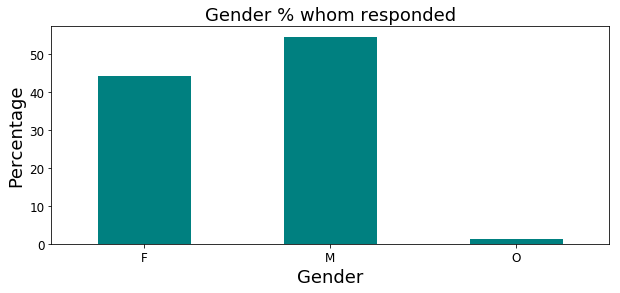

In [539]:
# Compare gender distribution in offers with highest response when offer was successful and unsuccessful



round(cust_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2).plot.bar(figsize=(10,4), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage', fontsize=18)
plt.title('Gender % whom responded', fontsize=18)
plt.show()


Text(0.5,1,'Gender % whom not responded')

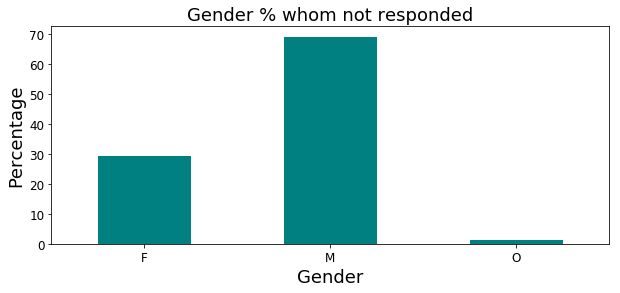

In [540]:

round(cust_not_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2).plot.bar(figsize=(10,4), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage', fontsize=18)
plt.title('Gender % whom not responded', fontsize=18)



#### Compare age distribution of customers in offers with highest response whom responded and whom did not responded

In [541]:
# Calculate percentage of each age group in highest response offer when offer was sucessful
age_grp_list = ['age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s']
round(cust_responded_high_rep_df[age_grp_list].mean()*100,2)

age_10s      0.96
age_20s      8.24
age_30s     10.34
age_40s     14.77
age_50s     24.99
age_60s     21.39
age_70s     11.58
age_80s      5.84
age_90s      1.68
age_100s     0.22
dtype: float64

In [542]:
# Calculate percentage of each age group in highest response offer when offer was unsucessful
round(cust_not_responded_high_rep_df[age_grp_list].mean()*100,2)

age_10s      1.94
age_20s     12.73
age_30s     10.97
age_40s     17.33
age_50s     19.58
age_60s     19.64
age_70s     12.00
age_80s      4.12
age_90s      1.58
age_100s     0.12
dtype: float64

Text(0.5,1,'Age Group % whom responded')

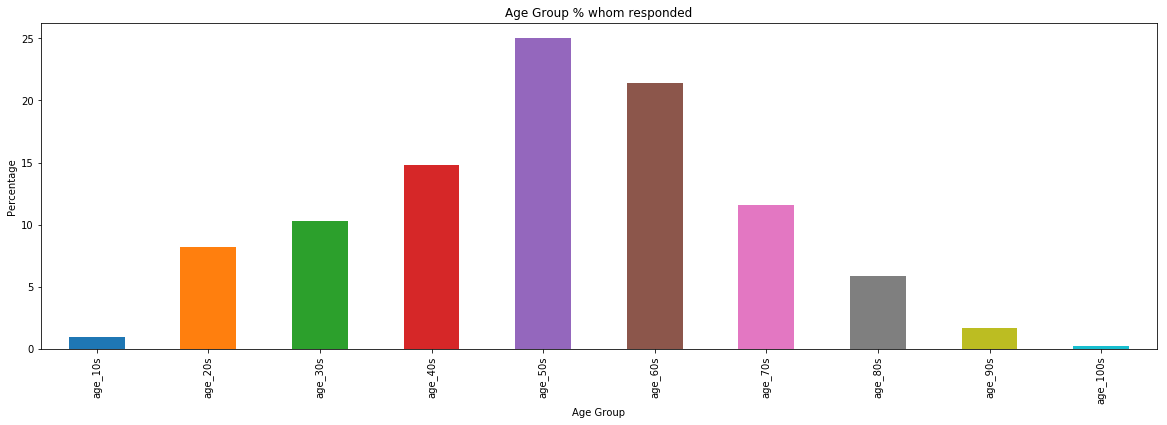

In [543]:


round(cust_responded_high_rep_df[age_grp_list].mean()*100,2).plot.bar(figsize=(20,6));
plt.ylabel('Percentage')
plt.xlabel ('Age Group')
plt.title('Age Group % whom responded')





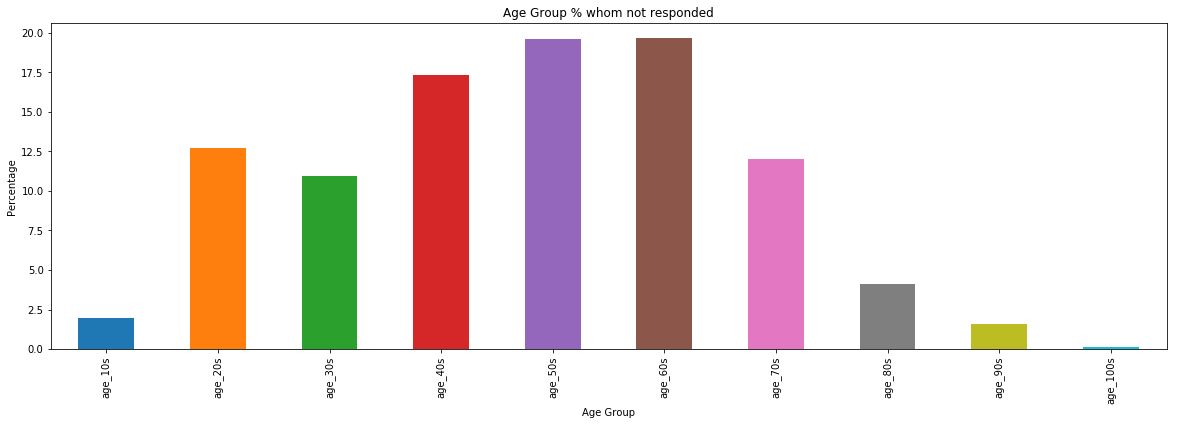

In [544]:
round(cust_not_responded_high_rep_df[age_grp_list].mean()*100,2).plot.bar(figsize=(20,6));
plt.ylabel('Percentage')
plt.xlabel ('Age Group')
plt.title('Age Group % whom not responded')
plt.show()

**Again, from above, we can observe that higher percentage of age distribution is 25% for age group age_50s when offer is successful and higher percentage of age distribution is 20% for age groups age_50s & age_60s when offer is unsuccessful**.

#### Compare income distribution of customers in offers with highest response whom responded and whom did not responded

In [545]:
# Calculate percentage of each income group in highest response offer when offer was sucessful
income_grp_list = ['income_30ths', 'income_40ths', 'income_50ths', 'income_60ths','income_70ths', 'income_80ths',\
                   'income_90ths', 'income_100ths', 'income_110ths', 'income_120ths']
round(cust_responded_high_rep_df[income_grp_list].mean()*100,2)

income_30ths     11.22
income_40ths     10.92
income_50ths     17.09
income_60ths     15.89
income_70ths     16.83
income_80ths     10.96
income_90ths      8.38
income_100ths     4.50
income_110ths     4.18
income_120ths     0.04
dtype: float64

In [546]:
# Calculate percentage of each income group in highest response offer when offer was unsucessful
round(cust_not_responded_high_rep_df[income_grp_list].mean()*100,2)

income_30ths     18.97
income_40ths     16.12
income_50ths     19.64
income_60ths     17.58
income_70ths     12.67
income_80ths      5.33
income_90ths      6.18
income_100ths     1.76
income_110ths     1.70
income_120ths     0.06
dtype: float64

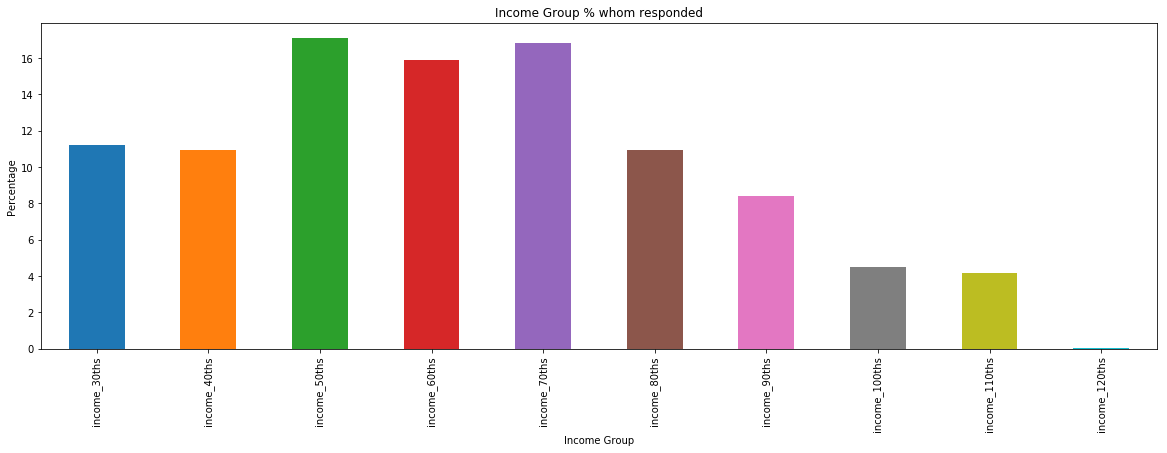

In [547]:
# Compare income group distribution in offers with highest response when offer was successful and unsuccessful

round(cust_responded_high_rep_df[income_grp_list].mean()*100,2).plot.bar(figsize=(20,6));
plt.ylabel('Percentage')
plt.xlabel ('Income Group')
plt.title('Income Group % whom responded')

plt.show()


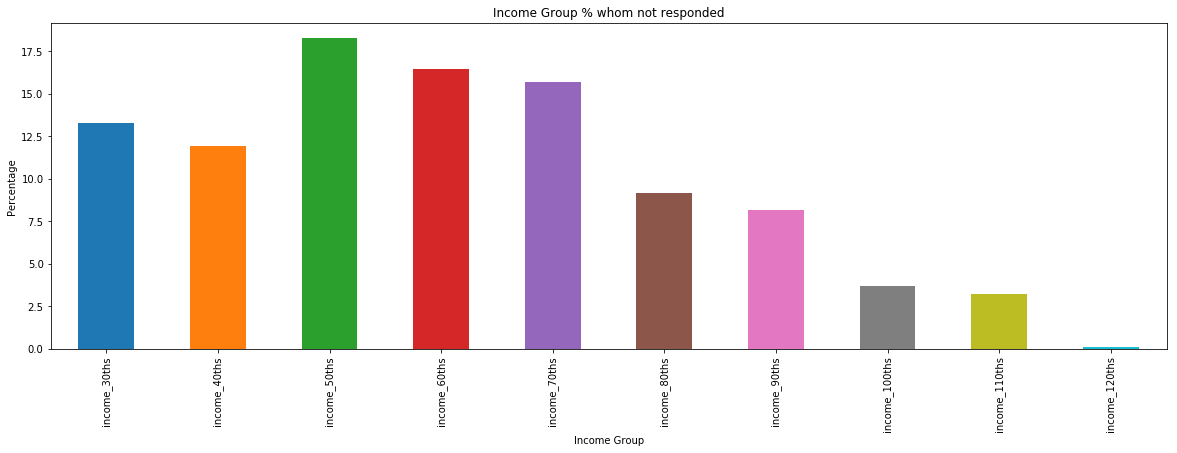

In [548]:
round(combined_data_low_resp_df[income_grp_list].mean()*100,2).plot.bar(figsize=(20,6));
plt.ylabel('Percentage')
plt.xlabel ('Income Group')
plt.title('Income Group % whom not responded')

plt.show()

**Again, from above, we can observe that higher percentage of income distribution is 17% for income group income_50ths & income_70ths when offer is successful and higher percentage of income distribution is 19% for age groups income_50ths & income_60ths when offer is unsuccessful**.

### Split the combined data into training and test data

**Before splitting the combined data, let us drop the features from combined data which would not play any role in training the model**.

In [549]:
# Drop features from combined_data_df which are not required for training the model
# Drop 'customer_id' & 'offer_id' as these are unique identifier
# Drop 'time' as it is not rqeuired. It was used to check if a customer responded to an offer or not
# and to calculate total amount
# Drop 'email' as it has only 1 value in all the observations and the value is 1
combined_data_df.drop(columns=['customer_id', 'offer_id', 'time', 'email'], inplace=True)
combined_data_df.head()

,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,membership_tenure,...,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount,cust_response
0,5,168,5,1,0,0,1,1,0,1105,...,0,0,0,0,0,1,0,0,37.67,1
1,0,72,0,0,0,1,0,1,1,1105,...,0,0,0,0,0,1,0,0,49.39,1
2,10,168,10,1,0,0,0,1,1,1105,...,0,0,0,0,0,1,0,0,48.28,1
3,5,120,5,1,0,0,1,1,1,1105,...,0,0,0,0,0,1,0,0,48.28,1
4,10,168,2,0,1,0,1,1,0,753,...,0,0,1,0,0,0,0,0,0.00,0


In [550]:
# Separate features and labels of combined_data_df
X = combined_data_df.drop(columns=['cust_response'])
y = combined_data_df.loc[:,['cust_response']]

In [551]:
# Distribution of target class
y.squeeze().value_counts()

1    35854
0    30647
Name: cust_response, dtype: int64

In [552]:
# percenatge of distribution of target class
round((y.squeeze().value_counts()/y.squeeze().count())*100,2)

1    53.91
0    46.09
Name: cust_response, dtype: float64

**From above, we can observe that our dataset is nearly balanced (slightly imbalanced) in terms of distribution of target class as our target class has nearly equal number of customers whom responded to offer(53.91%) and whom did not responded to an offer(46.09%).**

In [553]:
# Split features and labels into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [554]:
X_train.head()

,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,membership_tenure,...,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount
3422,0,96,0,0,0,1,1,1,0,1764,...,1,0,0,0,0,0,0,0,0,3.21
64365,10,168,10,1,0,0,0,1,1,1151,...,0,0,1,0,0,0,0,0,0,109.55
64981,10,168,2,0,1,0,1,1,0,855,...,0,0,0,1,0,0,0,0,0,87.60
59855,5,120,5,1,0,0,1,1,1,1345,...,0,1,0,0,0,0,0,0,0,55.47
27439,0,72,0,0,0,1,0,1,1,1740,...,0,1,0,0,0,0,0,0,0,46.86


### Scale selected features

In [555]:
# Prepare list of features to scale
feat_to_scale = ['difficulty', 'duration', 'reward', 'membership_tenure', 'total_amount']

In [556]:
# Prepare a function func_feat_scale to scale features in train and test set
def func_feat_scale(df, feat=feat_to_scale):
        """
    Scale list features in a given dataframe
    
    INPUT:
    - df (dataframe): dataframe having features to scale
    - feat (list): list of features in dataframe to scale
            
    OUTPUT:
    - scaled_df (dataframe): dataframe containing scaled features
    """
        # Prepare dataframe of only features to scale
        df_feat_scale = df.loc[:,feat]
        
        # Apply feature scaling to df
        scaler = MinMaxScaler()
        df_feat_scale = pd.DataFrame(scaler.fit_transform(df_feat_scale), columns = df_feat_scale.columns,\
                                     index=df_feat_scale.index)
        
        # Drop orignal features to scale from df and add scaled features back to df
        df = df.drop(columns=feat, axis=1)
        df_scaled = pd.concat([df, df_feat_scale], axis=1)
        
        return df_scaled

In [557]:
# Scale selected features in training set i.e. X_train
X_train_scaled = func_feat_scale(X_train, feat=feat_to_scale)
X_train_scaled.head()

,bogo,discount,informational,web,mobile,social,F,M,O,age_10s,...,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,difficulty,duration,reward,membership_tenure,total_amount
3422,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0.00,0.142857,0.0,0.604498,0.002862
64365,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,1.0,0.268239,0.097662
64981,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,0.2,0.105869,0.078094
59855,1,0,0,1,1,1,0,0,1,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.374657,0.049450
27439,0,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0.00,0.000000,0.0,0.591333,0.041775


## Train the classifier

In [560]:
# Create a baseline model against which we would compare our model to determine
# if our model is performing better than baseline model or not
# Our baseline model would predict that all users would respond to the offer
# So, we will calculate f1_score of the baseline model

baseline_model_f1_score = f1_score(y_train.squeeze().values, np.ones(y_train.shape[0]))
print('baseline model have f1_score: {}'.format(round(baseline_model_f1_score,4)))

baseline model have f1_score: 0.6996


In [569]:

def fit_classifier(clf, param_grid, X=X_train_scaled.values, y=y_train.squeeze().values):
  
    
    # cv uses StratifiedKFold
    # scoring f1 available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, verbose=1)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Duration : {} secs".format(time_taken))
    print("Best f1_score : {}".format(round(grid.best_score_,4)))
    print("------------------------------------------------------------------")   
    return grid.best_score_, grid.best_estimator_, time_taken

In [570]:
# Initialize classification algorithms
lor = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier

In [571]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in [lor, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training LogisticRegression :
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished


LogisticRegression
Duration : 4.84 secs
Best f1_score : 0.8429
------------------------------------------------------------------
Training RandomForestClassifier :
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


RandomForestClassifier
Duration : 4.15 secs
Best f1_score : 0.9216
------------------------------------------------------------------
Training AdaBoostClassifier :
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished


AdaBoostClassifier
Duration : 17.5 secs
Best f1_score : 0.896
------------------------------------------------------------------
Training GradientBoostingClassifier :
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.3s finished


GradientBoostingClassifier
Duration : 59.72 secs
Best f1_score : 0.9209
------------------------------------------------------------------


In [572]:
# Create clf_df dataframe from clf_dict
clf_dict['best_f1_score'] = clf_scores
clf_dict['time_taken(s)'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_f1_score,time_taken(s),best_est
LogisticRegression,0.842922,4.84,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.921618,4.15,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.896027,17.50,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.920881,59.72,([DecisionTreeRegressor(criterion='friedman_ms...


**Therefore, best performing classifier algorithm among the above 4 classifiers is RandomForestClassifier. f1 score of 0.92 and a duration of 4.15 seconds**

### Fine tune the trained model

In [583]:
# Tune the best classifier(RandomForestClassifier) with the help of param grid in GridSearchCV
# The fine tuned model will be used with the test set
param_grid = {'n_estimators': [10, 50, 80, 100],
              'max_depth': [None, 2, 3, 4],
              'min_samples_split': [2,3,4],
              'min_samples_leaf': [1,2,3],
             }

rfc = RandomForestClassifier(random_state=42)
rfc_best_score, rfc_best_est, _ = fit_classifier(rfc, param_grid)
rfc_best_est

Training RandomForestClassifier :
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 22.5min finished


RandomForestClassifier
Duration : 1353.63 secs
Best f1_score : 0.9319
------------------------------------------------------------------


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

**From above, we can observe that after fine tuning the trained RandomForestClassifier, we get improved and more better f1_score of 0.9319**.

### Feature Importances given by best estimator of trained model

In [584]:
# Print RandomForestClassifier best estimator feature importances
rfc_best_est.feature_importances_

array([  4.74e-03,   4.88e-03,   5.31e-03,   5.15e-03,   4.65e-03,
         1.87e-02,   6.82e-03,   7.28e-03,   1.15e-03,   1.75e-03,
         5.84e-03,   5.59e-03,   6.48e-03,   7.52e-03,   7.37e-03,
         6.07e-03,   4.19e-03,   2.16e-03,   1.31e-04,   1.18e-03,
         2.29e-03,   4.20e-03,   1.04e-02,   4.66e-03,   1.24e-02,
         4.26e-03,   3.87e-03,   4.21e-03,   4.32e-03,   4.21e-03,
         4.12e-03,   4.33e-03,   4.42e-03,   4.44e-03,   4.49e-03,
         4.56e-03,   4.47e-03,   7.92e-03,   6.78e-03,   6.17e-03,
         5.49e-03,   5.77e-03,   5.17e-03,   4.59e-03,   3.49e-03,
         3.85e-03,   2.52e-04,   1.61e-02,   1.55e-02,   1.45e-02,
         9.37e-02,   6.18e-01])

In [585]:
# Print shape of RandomForestClassifier best estimator feature importances
rfc_best_est.feature_importances_.shape

(52,)

In [586]:
# Prepare the dataframe of feature importances given to features by best estimator of RandomForestClassifier
feat_imp_df = pd.DataFrame(rfc_best_est.feature_importances_,\
                           index=X_train_scaled.columns.tolist(),\
                           columns=['feat_imp']).reset_index()

feat_imp_df.rename(columns={'index': 'feature'}, inplace=True)
feat_imp_df['feat_imp_perc'] = np.round((feat_imp_df['feat_imp']/feat_imp_df['feat_imp'].sum())*100,2)
feat_imp_df = feat_imp_df.sort_values(by=['feat_imp_perc'], ascending=False).reset_index(drop=True)
feat_imp_df

,feature,feat_imp,feat_imp_perc
0,total_amount,0.618193,61.82
1,membership_tenure,0.093657,9.37
2,social,0.018677,1.87
3,difficulty,0.016082,1.61
4,duration,0.015524,1.55
5,reward,0.014503,1.45
6,2018,0.012365,1.24
7,2016,0.010421,1.04
8,income_30ths,0.007922,0.79
9,age_50s,0.007517,0.75


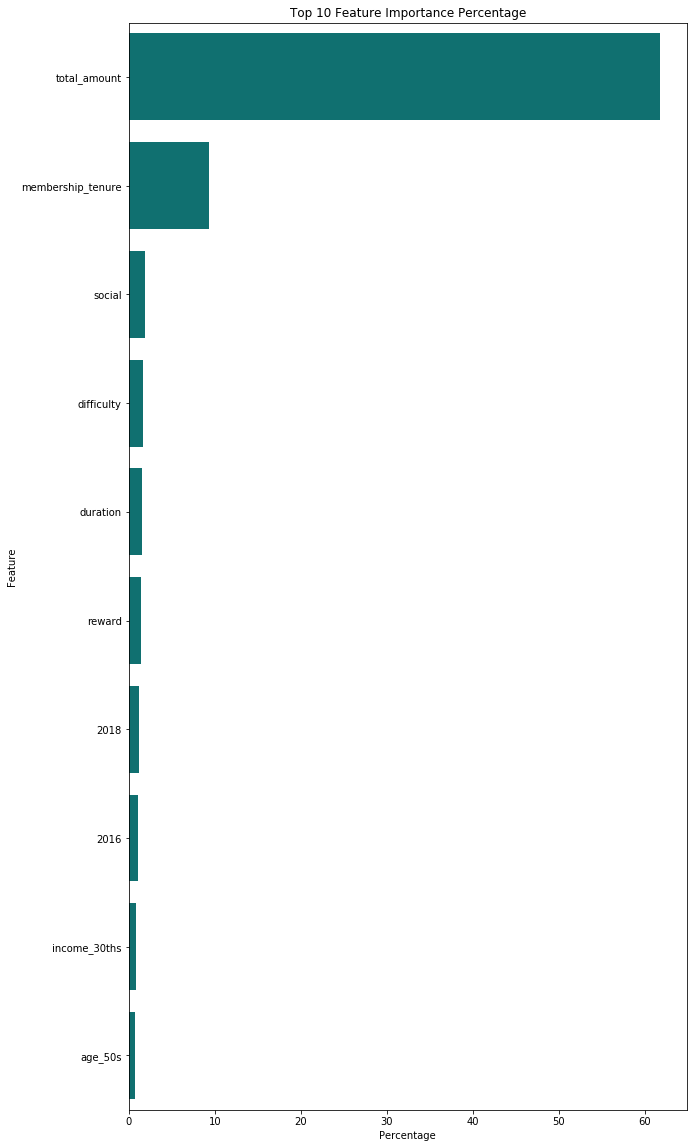

In [587]:
# Plot horizontal bar graph of features with their importances given by best estimator of RandomForestClassifier
fig, ax = plt.subplots(figsize=(10, 20),nrows=1,ncols=1)
sns.barplot(x='feat_imp_perc', y='feature', color='teal', data=feat_imp_df[:10])
plt.xlabel('Percentage')
#plt.xticks(rotation='horizontal')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance Percentage')
plt.show()

### Predict classes for the test data

In [588]:
# Prepare test data in order to predict classes for the test data
# Scale selected features in test set i.e. X_test
X_test_scaled = func_feat_scale(X_test, feat=feat_to_scale)
X_test_scaled.head()

,bogo,discount,informational,web,mobile,social,F,M,O,age_10s,...,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,difficulty,duration,reward,membership_tenure,total_amount
20034,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0.25,0.571429,0.5,0.503017,0.004838
55752,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,1.0,0.815688,0.016028
61495,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.399342,0.016362
34391,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.116292,0.000000
36619,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.149205,0.000669


In [589]:
# Print shape of dataframe X_test_scaled
X_test_scaled.shape

(16626, 52)

In [590]:
# Print shape of y_test
y_test.shape

(16626, 1)

In [591]:
# Classification of test data using best model trained on train data
y_pred = rfc_best_est.predict(X_test_scaled)
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [592]:
# Print shape of y_pred
y_pred.shape

(16626,)

### Confusion Matrix

In [593]:
# Calculate confusion matrix
confusion_matrix(y_test.squeeze().values, y_pred)

array([[6733,  873],
       [ 359, 8661]])

In [594]:
# Calculate tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, y_pred).ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 6733
false postives: 873
false negatives: 359
true postives: 8661


In [595]:
# Calculate precision, recall and f1_score of the test data
test_data_f1_score = f1_score(y_test.squeeze().values, y_pred)
test_data_precision_score = precision_score(y_test.squeeze().values.tolist(), y_pred)
test_data_recall_score = recall_score(y_test.squeeze().values, y_pred)
print('f1_score on test data: {}'.format(round(test_data_f1_score,4)))
print('precision score on test data: {}'.format(round(test_data_precision_score,4)))
print('recall score on test data: {}'.format(round(test_data_recall_score,4)))

f1_score on test data: 0.9336
precision score on test data: 0.9084
recall score on test data: 0.9602


**From above, we observe that the trained RandomForestClassifier best estimator produced f1_score of 0.9336 on test data, which is quite good.**

In [596]:
# Define function plot_confusion_matrix which plots confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    INPUT:
    - y_true (np.array): array containing true labels
    - y_pred (np.array): array containing predicted labels
    - normalize (boolean): boolean value to determine whether to normalize the confusion matrix or not
    - title (str): title to use in confusion matrix plot
            
    OUTPUT:
    - ax (Axes object): Axes object to plot confusion matrix plot
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[6733  873]
 [ 359 8661]]


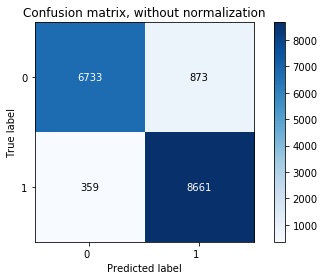

In [597]:
# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
class_names = np.array([0, 1])

plot_confusion_matrix(y_test.squeeze().values, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[ 0.89  0.11]
 [ 0.04  0.96]]


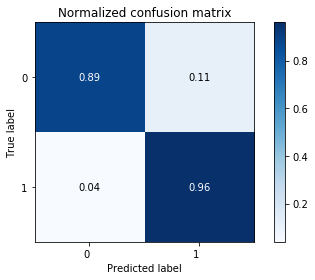

In [598]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test.squeeze().values, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Summary: 
 1. we observed that there are 4% of chances of misclassifying an indvidual whom would normally respond to an individual that would not respond to offer.
   
 2. Similarly, there are 11% of chances of misclassifying an individual whom would not respond to an individual whom would respond to an offer.
 
 ***With such high percentage of success, the predictive model is goos enough and applicable for the analysis of which customer will respond to offers***